In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OrdinalEncoder
from sklearn.inspection import permutation_importance
from sklearn.metrics import accuracy_score, f1_score, auc, roc_curve, roc_auc_score

In [2]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
pd.get_option("display.max_columns")
pd.set_option("display.max_columns", None)

In [3]:
df = pd.read_csv('soubor.csv',index_col=0)
slice_t = 1672531200
df_model = df.loc[df['match_start']<slice_t].fillna(0)
df_pred = df.loc[df['match_start']>=slice_t].fillna(0)

In [4]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7840 entries, 0 to 7839
Data columns (total 52 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   match_id                              7840 non-null   int64  
 1   date_planned_start                    7840 non-null   int64  
 2   match_start                           7840 non-null   int64  
 3   player_1                              7840 non-null   int64  
 4   player_2                              7840 non-null   int64  
 5   player_1_fh_goals                     7840 non-null   int64  
 6   player_2_fh_goals                     7840 non-null   int64  
 7   player_1_sh_goals                     7840 non-null   int64  
 8   player_2_sh_goals                     7840 non-null   int64  
 9   player_1_total_goals                  7840 non-null   int64  
 10  player_2_total_goals                  7840 non-null   int64  
 11  shift_n          

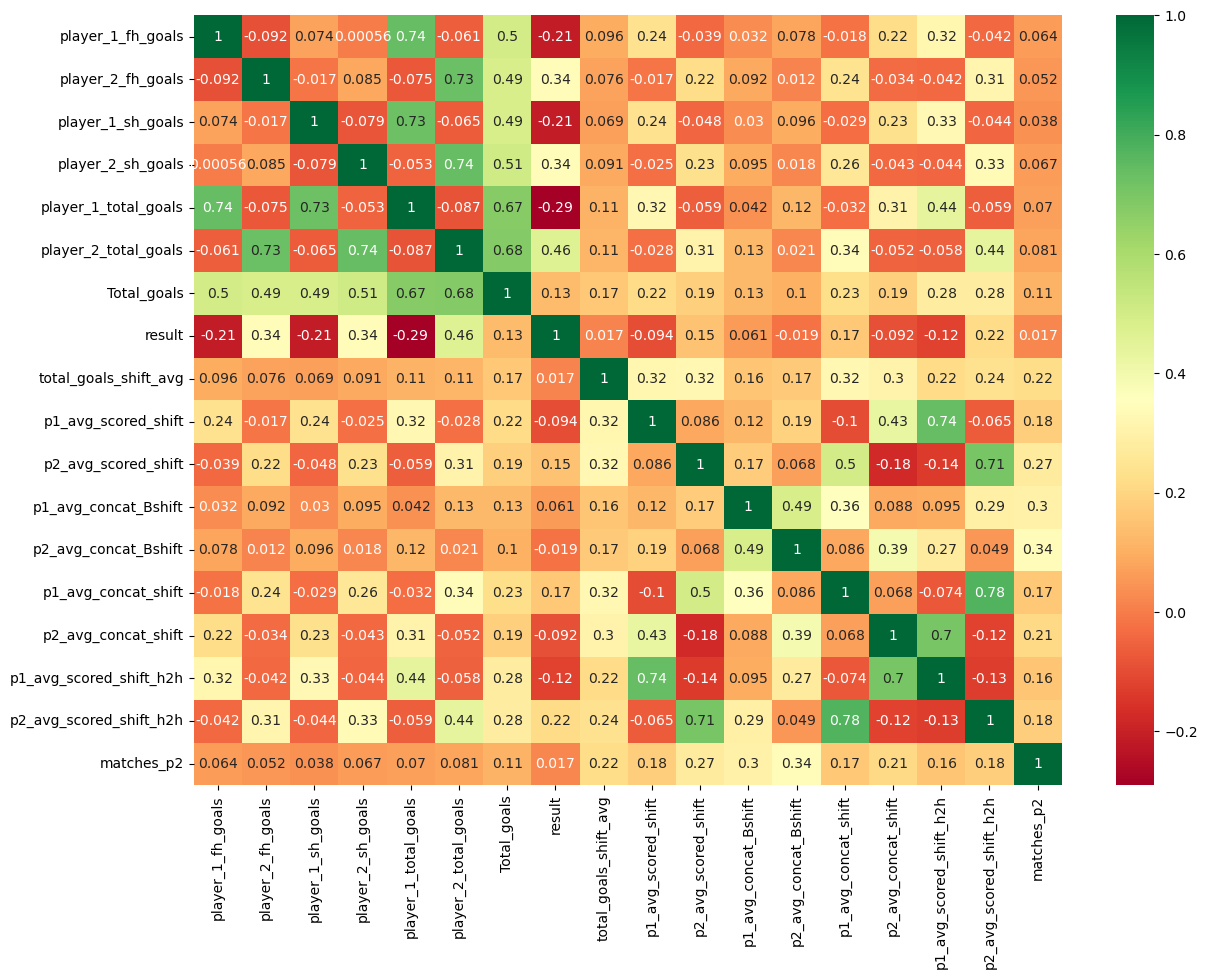

In [5]:
corrmat = df_model.corr()
top_corr_features = corrmat.index[abs(corrmat["Total_goals"])>0.1]
plt.figure(figsize=(14,10))
g = sns.heatmap(df_model[top_corr_features].corr(),annot=True,cmap="RdYlGn")

In [6]:
cols_to_drop = ['player_1_p2','Total_goals', 'result', 'p1_bilance', 'p2_bilance','wins_h2h_p2','wins_h2h','wins_p2','matches_p2','matches','wins','matchesh2h_p2']
df_model_1 = df_model.drop(cols_to_drop,axis=1).copy()
df_pred_1 = df_pred.drop(cols_to_drop,axis=1).copy()
# df_pred_1['p1_avg_scored_Bshift_h2h'] = df_pred_1.apply(lambda x: x['p1_avg_scored_Bshift_h2h'] if x['p1_avg_scored_Bshift_h2h'] > 0 else x['p1_avg_scored_Bshift'],axis=1)
# df_pred_1['p2_avg_scored_Bshift_h2h'] = df_pred_1.apply(lambda x: x['p2_avg_scored_Bshift_h2h'] if x['p2_avg_scored_Bshift_h2h'] > 0 else x['p2_avg_scored_Bshift'],axis=1)

In [7]:
df_model_1['h2h_momentum_p2'] = df_model_1['h2h_momentum']*-1
df_pred_1['h2h_momentum_p2'] = df_pred['h2h_momentum']*-1

In [8]:
df_model_1.iloc[:,12:].head()

,match_count_within_shift,match_count_within_shift_player_pair,cumulative_p1_shift,cumulative_p2_shift,cumulative_h2h_shift,total_goals_shift_avg,p1_avg_scored_Bshift,p2_avg_scored_Bshift,p1_avg_scored_shift,p2_avg_scored_shift,p1_avg_concat_Bshift,p2_avg_concat_Bshift,p1_avg_concat_shift,p2_avg_concat_shift,p1_avg_scored_Bshift_h2h,p2_avg_scored_Bshift_h2h,p1_avg_scored_shift_h2h,p2_avg_scored_shift_h2h,p1_momentum_s_total,p2_momentum_s_total,h2h_momentum,p1_goals_momentum_s,p2_goals_momentum_s,win_rate,matchesh2h,win_rate_h2h,win_rate_p2,win_rate_h2h_p2,h2h_momentum_p2
0,1,1,0,0,0,0.000000,0.0,0.0,1.888889,2.058824,0.0,0.0,2.555556,2.470588,0.0,0.0,2.333333,2.888889,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0,0.0,0.0,0.0,-0.000000
1,2,1,0,0,0,4.000000,0.0,0.0,1.888889,2.411765,0.0,0.0,2.555556,1.294118,0.0,0.0,1.444444,2.222222,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0,0.0,0.0,0.0,-0.000000
2,3,1,1,0,0,4.500000,0.0,0.0,2.411765,2.058824,0.0,0.0,1.294118,2.470588,0.0,0.0,2.625000,1.125000,0.447214,0.000000,0.000000,0.447214,0.000000,1.0,0,0.0,0.0,0.0,-0.000000
3,4,2,-1,-1,0,4.333333,0.0,0.0,1.888889,2.058824,0.0,0.0,2.555556,2.470588,0.0,0.0,2.333333,2.888889,-0.680074,-0.680074,0.000000,-0.680074,-0.680074,0.0,1,0.0,0.0,0.0,-0.000000
4,5,2,-2,2,-1,4.750000,0.0,0.0,1.888889,2.411765,0.0,0.0,2.555556,1.294118,0.0,0.0,1.444444,2.222222,-1.089725,0.813941,-0.447214,-1.089725,0.813941,0.0,1,0.0,1.0,1.0,0.447214


In [9]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

cols_to_model = ['cumulative_h2h_shift','total_goals_shift_avg','p1_avg_scored_Bshift','p1_avg_scored_shift','p2_avg_concat_Bshift','p2_avg_concat_shift','p1_avg_scored_shift_h2h','p1_avg_scored_Bshift_h2h','p1_momentum_s_total','p2_momentum_s_total','h2h_momentum','h2h_momentum_p2','p1_goals_momentum_s','win_rate','win_rate_p2','win_rate_h2h','matchesh2h']
#df_model_1 = df_model_1[(df_model_1['player_1_total_goals'] <6) & (df_model_1['player_2_total_goals'] <6)]
X = df_model_1.iloc[:, 12:]
scaler = StandardScaler()

y = df_model_1.iloc[:, [9,10]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [10]:
import numpy as np
import tensorflow as tf


# Vytvoření modelu neuronové sítě s BatchNormalization
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(32, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(2, activation='exponential')
])

# Kompilace modelu s Poissonovým rozdělením
model.compile(optimizer='adam', loss='poisson')

# Trénování modelu
model.fit(X_train, y_train, epochs=70, batch_size=16, validation_data=(X_test, y_test))

# Predikce na testovacích datech
y_pred = np.round(model.predict(X_test)).astype(int)



Epoch 1/70
343/343 [==============================] - 2s 2ms/step - loss: 1.1010 - val_loss: 0.6042
Epoch 2/70
343/343 [==============================] - 1s 2ms/step - loss: 0.6086 - val_loss: 0.5007
Epoch 3/70
343/343 [==============================] - 1s 2ms/step - loss: 0.5277 - val_loss: 0.4619
Epoch 4/70
343/343 [==============================] - 1s 2ms/step - loss: 0.4939 - val_loss: 0.4486
Epoch 5/70
343/343 [==============================] - 1s 2ms/step - loss: 0.4761 - val_loss: 0.4419
Epoch 6/70
343/343 [==============================] - 1s 2ms/step - loss: 0.4661 - val_loss: 0.4372
Epoch 7/70
343/343 [==============================] - 1s 2ms/step - loss: 0.4520 - val_loss: 0.4283
Epoch 8/70
343/343 [==============================] - 1s 2ms/step - loss: 0.4520 - val_loss: 0.4256
Epoch 9/70
343/343 [==============================] - 1s 2ms/step - loss: 0.4399 - val_loss: 0.4175
Epoch 10/70
343/343 [==============================] - 1s 2ms/step - loss: 0.4408 - val_loss: 0.4117

In [11]:
val = scaler.fit_transform(df_pred_1.iloc[:, 12:])


In [12]:
y_pred_1 = np.round(model.predict(X_test)).astype(int)

74/74 [==============================] - 0s 739us/step


In [13]:
y_pred_1 = model.predict(val)

231/231 [==============================] - 0s 739us/step


In [14]:
np.min(y_pred_1)


0.6245567

In [15]:
np.unique(np.round(y_pred_1[:,0]))

array([1., 2., 3., 4., 5.], dtype=float32)

In [16]:
df_pred_1[df_pred_1['cumulative_p1_shift'] == df_pred_1['cumulative_p1_shift'] .min()]['shift_n']

10930    916.0
Name: shift_n, dtype: float64

In [17]:
abs(np.round(y_pred_1[:,0])+np.round(y_pred_1[:,1]) - df_pred['Total_goals'].values).mean()

1.5276422764227642

In [18]:
abs(y_pred_1[:,0] - df_pred['player_1_total_goals'].values).mean()

1.0830695399100865

In [19]:
df_result = df_pred.iloc[:,:15].copy()
df_result

,match_id,date_planned_start,match_start,player_1,player_2,player_1_fh_goals,player_2_fh_goals,player_1_sh_goals,player_2_sh_goals,player_1_total_goals,player_2_total_goals,shift_n,match_count_within_shift,match_count_within_shift_player_pair,Total_goals
7840,151750,1672531680,1672531678,2,29,0,1,0,1,0,2,870.0,23,8,2
7841,151751,1672532520,1672532517,4,29,1,0,0,0,1,0,870.0,24,8,1
7842,151752,1672535040,1672535041,2,4,1,2,2,0,3,2,870.0,25,9,5
7843,151753,1672535880,1672535877,2,29,1,3,1,0,2,3,870.0,26,9,5
7844,151754,1672536720,1672536719,4,29,1,1,0,0,1,1,870.0,27,9,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15215,233087,1677452280,1677452288,9,15,2,0,1,2,3,2,983.0,18,6,5
15216,232144,1677453120,1677453131,15,29,0,0,1,1,1,1,983.0,19,7,2
15217,232145,1677453960,1677453967,9,29,1,1,1,2,2,3,983.0,20,7,5
15218,232146,1677454800,1677454807,9,15,1,2,0,3,1,5,983.0,21,7,6


In [20]:
df_result['player_1_total_goals_est'] = np.round(y_pred_1[:,0]).astype(int)
df_result['player_2_total_goals_est'] = np.round(y_pred_1[:,1]).astype(int)
df_result['total_goals_est'] = df_result['player_1_total_goals_est'] + df_result['player_2_total_goals_est']
df_result

,match_id,date_planned_start,match_start,player_1,player_2,player_1_fh_goals,player_2_fh_goals,player_1_sh_goals,player_2_sh_goals,player_1_total_goals,player_2_total_goals,shift_n,match_count_within_shift,match_count_within_shift_player_pair,Total_goals,player_1_total_goals_est,player_2_total_goals_est,total_goals_est
7840,151750,1672531680,1672531678,2,29,0,1,0,1,0,2,870.0,23,8,2,1,2,3
7841,151751,1672532520,1672532517,4,29,1,0,0,0,1,0,870.0,24,8,1,3,2,5
7842,151752,1672535040,1672535041,2,4,1,2,2,0,3,2,870.0,25,9,5,2,2,4
7843,151753,1672535880,1672535877,2,29,1,3,1,0,2,3,870.0,26,9,5,2,2,4
7844,151754,1672536720,1672536719,4,29,1,1,0,0,1,1,870.0,27,9,2,3,2,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15215,233087,1677452280,1677452288,9,15,2,0,1,2,3,2,983.0,18,6,5,2,3,5
15216,232144,1677453120,1677453131,15,29,0,0,1,1,1,1,983.0,19,7,2,1,1,2
15217,232145,1677453960,1677453967,9,29,1,1,1,2,2,3,983.0,20,7,5,3,2,5
15218,232146,1677454800,1677454807,9,15,1,2,0,3,1,5,983.0,21,7,6,2,3,5


In [21]:
print(f"Mean absolute error: {abs(df_result['Total_goals'] - df_result['total_goals_est']).mean()}")

Mean absolute error: 1.5276422764227642


In [22]:
 y_pred_1.shape

(7380, 2)

In [23]:
df_pred_1[df_pred_1['shift_n']==916]

,match_id,date_planned_start,match_start,player_1,player_2,player_1_fh_goals,player_2_fh_goals,player_1_sh_goals,player_2_sh_goals,player_1_total_goals,player_2_total_goals,shift_n,match_count_within_shift,match_count_within_shift_player_pair,cumulative_p1_shift,cumulative_p2_shift,cumulative_h2h_shift,total_goals_shift_avg,p1_avg_scored_Bshift,p2_avg_scored_Bshift,p1_avg_scored_shift,p2_avg_scored_shift,p1_avg_concat_Bshift,p2_avg_concat_Bshift,p1_avg_concat_shift,p2_avg_concat_shift,p1_avg_scored_Bshift_h2h,p2_avg_scored_Bshift_h2h,p1_avg_scored_shift_h2h,p2_avg_scored_shift_h2h,p1_momentum_s_total,p2_momentum_s_total,h2h_momentum,p1_goals_momentum_s,p2_goals_momentum_s,win_rate,matchesh2h,win_rate_h2h,win_rate_p2,win_rate_h2h_p2,h2h_momentum_p2
10837,183561,1674543600,1674543597,9,22,1,0,0,0,1,0,916.0,1,1,0,0,0,0.000000,1.982972,2.117054,2.025641,2.500000,2.130031,2.119380,1.692308,1.368421,2.227273,2.030303,1.4,1.7,0.000000,0.000000,0.000000,0.000000,0.000000,0.345201,66,0.424242,0.393798,0.333333,-0.000000
10838,183562,1674543720,1674543715,15,28,1,1,1,2,2,3,916.0,2,1,0,0,0,1.000000,1.863394,2.459736,1.179487,2.236842,2.341515,2.436298,3.230769,2.184211,1.666667,3.111111,1.4,2.8,0.000000,0.000000,0.000000,0.000000,0.000000,0.302028,45,0.111111,0.415264,0.644444,-0.000000
10839,183563,1674544440,1674544435,9,27,0,1,2,0,2,1,916.0,3,1,1,0,0,3.000000,1.982972,2.205536,2.025641,2.473684,2.130031,1.959862,1.692308,1.894737,1.636364,1.954545,1.2,1.8,0.447214,0.000000,0.000000,0.447214,0.000000,0.346213,110,0.336364,0.432526,0.472727,-0.000000
10840,183564,1674544560,1674544562,15,22,0,1,0,2,0,3,916.0,4,1,-1,-1,0,3.000000,1.863394,2.117054,1.179487,2.500000,2.341515,2.119380,3.230769,1.368421,1.381818,2.563636,0.7,3.1,-0.447214,-0.447214,0.000000,-0.447214,-0.447214,0.301706,55,0.200000,0.393493,0.636364,-0.000000
10841,183565,1674545280,1674545274,27,28,3,0,1,2,4,2,916.0,5,1,-1,1,0,3.000000,2.205536,2.459736,2.473684,2.236842,1.959862,2.436298,1.894737,2.184211,2.472656,2.250000,2.9,2.4,-0.447214,0.447214,0.000000,-0.447214,0.447214,0.432227,256,0.429688,0.415616,0.351562,-0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10928,183652,1674583200,1674583193,15,28,0,2,0,1,0,3,916.0,92,10,-24,3,-7,4.219780,1.863394,2.459736,1.179487,2.236842,2.341515,2.436298,3.230769,2.184211,1.666667,3.111111,1.4,2.8,-1.702939,0.447214,-1.474788,-1.702939,0.447214,0.292909,54,0.092593,0.416471,0.666667,1.474788
10929,183653,1674583920,1674583919,9,27,0,1,0,1,0,2,916.0,93,10,1,6,-1,4.206522,1.982972,2.205536,2.025641,2.473684,2.130031,1.959862,1.692308,1.894737,1.636364,1.954545,1.2,1.8,-1.474788,1.795828,-1.308625,-1.474788,1.795828,0.349927,119,0.336134,0.433491,0.470588,1.308625
10930,183654,1674584040,1674584034,15,22,0,1,0,1,0,2,916.0,94,10,-25,14,-8,4.182796,1.863394,2.117054,1.179487,2.500000,2.341515,2.119380,3.230769,1.368421,1.381818,2.563636,0.7,3.1,-1.778342,1.089725,-1.541104,-1.778342,1.089725,0.292608,64,0.171875,0.400904,0.671875,1.541104
10931,183656,1674584880,1674584756,9,15,2,0,1,1,3,1,916.0,96,10,0,-26,6,4.159574,1.982972,1.863394,2.025641,1.179487,2.130031,2.341515,1.692308,3.230769,2.076923,1.230769,3.7,1.2,-1.643168,-1.850676,1.405347,-1.643168,-1.850676,0.349415,48,0.604167,0.292308,0.187500,-1.405347


In [24]:
df_result[(df_result['shift_n']==916) & (df_result['player_1']==15)]

,match_id,date_planned_start,match_start,player_1,player_2,player_1_fh_goals,player_2_fh_goals,player_1_sh_goals,player_2_sh_goals,player_1_total_goals,player_2_total_goals,shift_n,match_count_within_shift,match_count_within_shift_player_pair,Total_goals,player_1_total_goals_est,player_2_total_goals_est,total_goals_est
10838,183562,1674543720,1674543715,15,28,1,1,1,2,2,3,916.0,2,1,5,1,2,3
10840,183564,1674544560,1674544562,15,22,0,1,0,2,0,3,916.0,4,1,3,1,3,4
10844,183568,1674546240,1674546227,15,27,1,3,0,1,1,4,916.0,8,1,5,1,3,4
10848,183572,1674547920,1674547923,15,28,0,0,1,2,1,2,916.0,12,2,3,1,3,4
10850,183574,1674548760,1674548765,15,22,0,0,0,2,0,2,916.0,14,2,2,1,3,4
10854,183578,1674550440,1674550435,15,27,0,0,1,1,1,1,916.0,18,2,2,1,3,4
10858,183582,1674552120,1674552121,15,28,1,1,0,1,1,2,916.0,22,3,3,2,3,5
10860,183584,1674552960,1674552962,15,22,0,3,0,2,0,5,916.0,24,3,5,1,3,4
10864,183588,1674554640,1674554648,15,27,1,3,1,5,2,8,916.0,28,3,10,1,3,4
10868,183592,1674556320,1674556313,15,28,0,0,1,3,1,3,916.0,32,4,4,2,3,5
